# Imports and Helpers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [ ]:
def plotter(df,hide_axis=True):
  fig, (ax1,ax2,ax3) = plt.subplots(3,1)

  sns.histplot(df["Recency"],ax=ax1,kde=True,stat='probability')
  sns.histplot(df["Frequency"],ax=ax2,kde=True,stat='probability')
  sns.histplot(df["MonetaryValue"],ax=ax3,kde=True,stat='probability')
  if hide_axis:
    ax1.get_xaxis().set_visible(False) ; ax2.get_xaxis().set_visible(False) ; ax3.get_xaxis().set_visible(False)
  plt.tight_layout()

# Data

In [ ]:
data = pd.read_csv("./RFM_DF/datamart.csv",index_col=0)

In [ ]:
data.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level_3,RFM_Level_5
CustomerID,,,,,,,,,,
12747,2,27,992.82,4,4,4,12,444,Top,Whale
12748,1,967,7522.06,4,4,4,12,444,Top,Whale
12749,4,37,813.45,4,4,4,12,444,Top,Whale
12820,3,17,268.02,4,3,3,10,433,Top,Safe
12822,71,9,146.15,2,2,3,7,223,Middle,Middle


In [ ]:
data_rfm = data.loc[:,["Recency","Frequency","MonetaryValue"]]

# Pre-Processing

In [ ]:
X = data_rfm.copy()

In [ ]:
data_rfm.describe().loc[["mean","std"]]

,Recency,Frequency,MonetaryValue
mean,94.298568,19.147257,380.535069
std,99.974969,44.831615,1474.285937


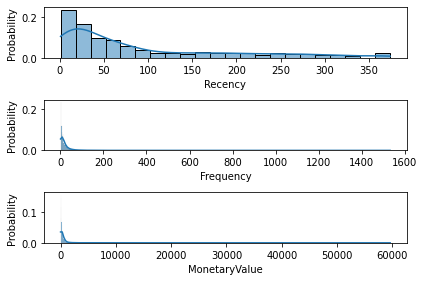

In [ ]:
plotter(X,hide_axis=False)

The data is skewed right and non-standardized. To deal with this, use a pipeline with a Box-Cox transformer and Standard Scaler

In [ ]:
pipe = Pipeline([
                 ('transformer',PowerTransformer(method='box-cox')),
                 ('scaler',StandardScaler())])

X_processed = pipe.fit_transform(X.values)

In [ ]:
X_processed_df = pd.DataFrame(X_processed,columns=data_rfm.columns,index=data_rfm.index)

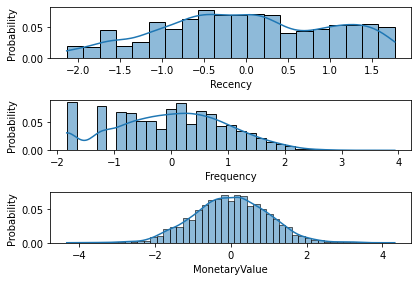

In [ ]:
plotter(X_processed_df,hide_axis=False)

# Choose Number of Clusters

## Elbow Method

In [ ]:
from collections import defaultdict

inertias = defaultdict()

# Fit KMeans and calculate intertieas for each k
for k in range(1, 12): 
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_processed)
    inertias[k] = kmeans.inertia_

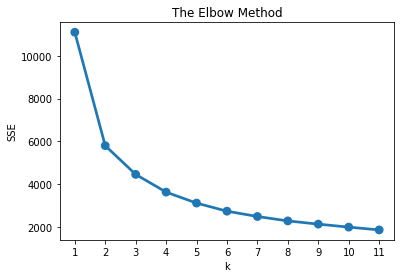

In [ ]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot inertia values for each key in the dictionary
sns.pointplot(x=list(inertias.keys()), y=list(inertias.values()))
plt.show()

From the elbow method, there should be around 2-5 Clusters

# Compare K-Means with k=2,3,5

**For values of k = (2,3,5), perform k-means and add cluster labels to df**

In [ ]:
labels = defaultdict(list)
for k in [2,3,5]:
  kmeans = KMeans(n_clusters=k, random_state=1) 
  kmeans.fit(X_processed)

  col_name = "label_k" + str(k)
  labels[col_name] = kmeans.labels_


**Look at mean values of RFM across segments**

In [ ]:
# Create a DataFrame by adding a new cluster label column
data_rfm_k2 = data_rfm.assign(Cluster=labels['label_k2'])
data_rfm_k3 = data_rfm.assign(Cluster=labels['label_k3'])
data_rfm_k5 = data_rfm.assign(Cluster=labels['label_k5'])

aggs = []
for df in [data_rfm_k2,data_rfm_k3,data_rfm_k5]:
  # Group the data by cluster
  grouped = df.groupby(['Cluster'])

  # Calculate average RFM values and segment sizes per cluster value
  agg = grouped.agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue': ['mean', 'count']
    }).round(1)

  aggs.append(agg)

print(aggs[0], "\n",aggs[1], "\n", aggs[2])

        Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         151.0       5.0          87.3  1896
1          34.7      34.0         688.6  1805 
         Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         184.9       3.0          53.0  1109
1          19.6      47.9        1000.2  1052
2          80.0      11.1         193.1  1540 
         Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         178.0       1.7          27.5   531
1          11.1      60.8        1332.4   663
2         205.4       6.6         125.9   822
3          61.5      20.3         363.3   924
4          28.2       7.1          93.5   761


The clustering across 2 clusters does not seem to separate the data enough. This makes sense as we expect clusters to be similar to their RFM segments

## Snake Plots

In [ ]:
X_processed_wc = pd.DataFrame(X_processed,index=X.index,columns=X.columns).assign(
    k_3=data_rfm_k3['Cluster'],
    k_5=data_rfm_k5['Cluster']
    )

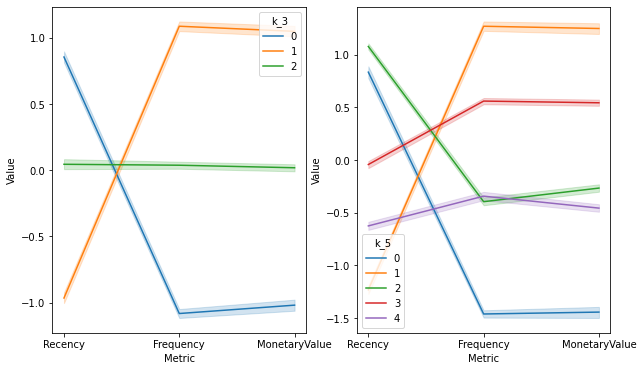

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,6))

for ax,col in list(zip(axes.flatten(),['k_3','k_5'])):
  
  # Melt the normalized dataset and reset the index 
  data_melt = pd.melt(
  					X_processed_wc.reset_index(), 
            id_vars=['CustomerID', col],
            value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
            var_name='Metric', value_name='Value'
					)
  
  # Create Plot
  num_colors = X_processed_wc[col].nunique()
  sns.lineplot(data=data_melt, x='Metric', y='Value', hue=col,ax=ax,palette=sns.color_palette()[:num_colors])
  

## Relative Importance

Note: Cluster label order is random

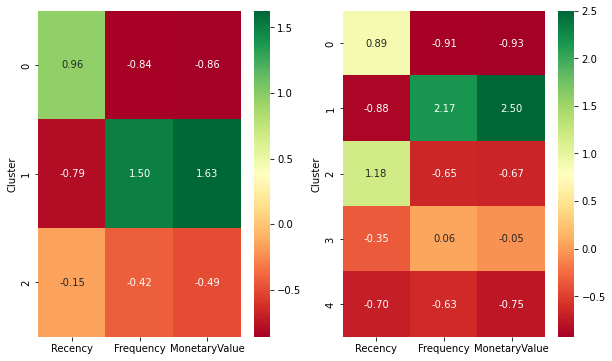

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,6))

for ax,df in list(zip(axes.flatten(),[data_rfm_k3,data_rfm_k5])):
  
 
  cluster_avg = df.groupby(['Cluster']).mean() 
  population_avg = data_rfm.mean()

  # Calculate relative importance of cluster's attribute value compared to population
  relative_imp = cluster_avg / population_avg   - 1

  # Create Plot
  sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn',ax=ax)

# Plot Clusters

In [ ]:
df_tsne = pd.read_csv(path + "/tsne.csv",index_col=0)

In [ ]:
df_tsne['k_3'] = X_processed_wc['k_3']
df_tsne['k_5'] = X_processed_wc['k_5']

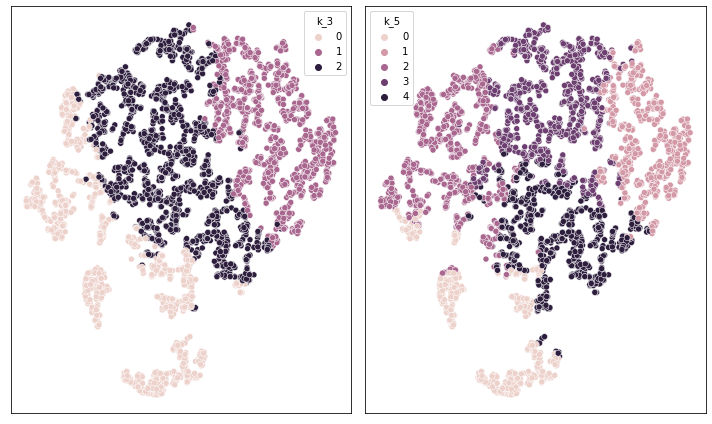

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))

sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2",data=df_tsne,hue="k_3",ax=ax1)
sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2",data=df_tsne,hue="k_5",ax=ax2)
ax1.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.tight_layout()

So, unlike the RFM Segments, k-means didn't separate the data in a strictly linear fashion (higher values of x1,x2,x3 -> higher cluster). 